# Table of Contents
 <p><div class="lev1"><a href="#examples"><span class="toc-item-num">1&nbsp;&nbsp;</span>examples</a></div><div class="lev2"><a href="#Parallel-options-pricing"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parallel options pricing</a></div><div class="lev3"><a href="#Problem-setup"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Problem setup</a></div><div class="lev3"><a href="#Monte-Carlo-option-pricing-function"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Monte-Carlo option pricing function</a></div><div class="lev3"><a href="#Parallel-computation-across-strike-prices-and-volatilities"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Parallel computation across strike prices and volatilities</a></div><div class="lev3"><a href="#Process-and-visualize-results"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Process and visualize results</a></div>

# examples

## Parallel options pricing

An option is a financial contract that gives the buyer of the contract the right to buy (a “call”) or sell (a “put”) a secondary asset (a stock for example) at a particular date in the future (the expiration date) for a pre-agreed upon price (the strike price). For this right, the buyer pays the seller a premium (the option price). There are a wide variety of flavors of options (American, European, Asian, etc.) that are useful for different purposes: hedging against risk, speculation, etc.

Much of modern finance is driven by the need to price these contracts accurately based on what is known about the properties (such as volatility) of the underlying asset. One method of pricing options is to use a Monte Carlo simulation of the underlying asset price. In this example we use this approach to price both European and Asian (path dependent) options for various strike prices and volatilities.

### Problem setup

In [1]:
from __future__ import print_function # legacy Python support
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time
import numpy as np

Here are the basic parameters for our computation

In [2]:
price = 100.0  # Initial price
rate = 0.05  # Interest rate
days = 260  # Days to expiration
paths = 10000  # Number of MC paths
n_strikes = 10 #6  # Number of strike values
min_strike = 90.0  # Min strike price
max_strike = 110.0  # Max strike price
n_sigmas = 10 #5  # Number of volatility values
min_sigma = 0.1  # Min volatility
max_sigma = 0.4  # Max volatility

In [3]:
strike_vals = np.linspace(min_strike, max_strike, n_strikes)
sigma_vals = np.linspace(min_sigma, max_sigma, n_sigmas)

In [4]:
print("Strike prices: ", strike_vals)
print("Volatilities: ", sigma_vals)

Strike prices:  [  90.           92.22222222   94.44444444   96.66666667   98.88888889
  101.11111111  103.33333333  105.55555556  107.77777778  110.        ]
Volatilities:  [ 0.1         0.13333333  0.16666667  0.2         0.23333333  0.26666667
  0.3         0.33333333  0.36666667  0.4       ]


### Monte-Carlo option pricing function

The following function computes the price of a single option. It returns the call and put prices for both European and Asian style options.

In [5]:
def price_option(S=100.0, K=100.0, sigma=0.25, r=0.05, days=260, paths=10000):
    """
    Price European and Asian options using a Monte Carlo method.

    Parameters
    ----------
    S : float
        The initial price of the stock.
    K : float
        The strike price of the option.
    sigma : float
        The volatility of the stock.
    r : float
        The risk free interest rate.
    days : int
        The number of days until the option expires.
    paths : int
        The number of Monte Carlo paths used to price the option.

    Returns
    -------
    A tuple of (E. call, E. put, A. call, A. put) option prices.
    """
    import numpy as np
    from math import exp,sqrt
    
    h = 1.0/days
    const1 = exp((r-0.5*sigma**2)*h)
    const2 = sigma*sqrt(h)
    stock_price = S*np.ones(paths, dtype='float64')
    stock_price_sum = np.zeros(paths, dtype='float64')
    for j in range(days):
        growth_factor = const1*np.exp(const2*np.random.standard_normal(paths))
        stock_price = stock_price*growth_factor
        stock_price_sum = stock_price_sum + stock_price
    stock_price_avg = stock_price_sum/days
    zeros = np.zeros(paths, dtype='float64')
    r_factor = exp(-r*h*days)
    euro_put = r_factor*np.mean(np.maximum(zeros, K-stock_price))
    asian_put = r_factor*np.mean(np.maximum(zeros, K-stock_price_avg))
    euro_call = r_factor*np.mean(np.maximum(zeros, stock_price-K))
    asian_call = r_factor*np.mean(np.maximum(zeros, stock_price_avg-K))
    return (euro_call, euro_put, asian_call, asian_put)

We can time a single call of this function using the %timeit magic:

In [6]:
%time result = price_option(S=100.0, K=100.0, sigma=0.25, r=0.05, days=260, paths=10000)
result

CPU times: user 242 ms, sys: 523 µs, total: 243 ms
Wall time: 251 ms


(12.129130725319321,
 7.4481859353083344,
 6.7775342282120716,
 4.4450971559650156)

### Parallel computation across strike prices and volatilities

The Client is used to setup the calculation and works with all engines.

In [15]:
import ipyparallel as ipp
rc = ipp.Client(profile='parallel-examples')


A LoadBalancedView is an interface to the engines that provides dynamic load balancing at the expense of not knowing which engine will execute the code.

In [16]:
view = rc.load_balanced_view()

Submit tasks for each (strike, sigma) pair. Again, we use the %%timeit magic to time the entire computation.

In [17]:
async_results = []

In [18]:
%%time

for strike in strike_vals:
    for sigma in sigma_vals:
        # This line submits the tasks for parallel computation.
        ar = view.apply_async(price_option, price, strike, sigma, rate, days, paths)
        async_results.append(ar)

rc.wait_interactive(async_results)  # Wait until all tasks are done.

 100/100 tasks finished after   10 s
done
CPU times: user 784 ms, sys: 40.7 ms, total: 824 ms
Wall time: 10.6 s


In [19]:
len(async_results)

100

### Process and visualize results

Retrieve the results using the get method:

In [20]:
results = [ar.get() for ar in async_results]

Assemble the result into a structured NumPy array.

In [21]:
prices = np.empty(n_strikes*n_sigmas,
    dtype=[('ecall',float),('eput',float),('acall',float),('aput',float)]
)

for i, price in enumerate(results):
    prices[i] = tuple(price)

prices.shape = (n_strikes, n_sigmas)

Plot the values of the European call in (volatility, strike) space.

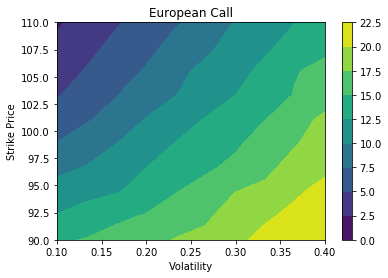

In [22]:
plt.figure()
plt.contourf(sigma_vals, strike_vals, prices['ecall'])
plt.axis('tight')
plt.colorbar()
plt.title('European Call')
plt.xlabel("Volatility")
plt.ylabel("Strike Price")